## Jack's Car Rental

The original problem statement from Chapter 4:

> **Example 4.2**: Jack’s Car Rental Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited $10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of $2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{\lambda^n}{n!}e^{-\lambda}$, where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of 5 cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma$ = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.


In [67]:
from dataclasses import dataclass


@dataclass
class Config:
    max_cars: int = 20
    """Maximum number of cars that can be present at either location."""

    max_moves: int = 5
    """Maximum number of cars that can be moved between both locations in a night."""

    requests_lambda: tuple[float, float] = (3, 4)
    """Expected number of car requests at both locations."""

    returns_lambda: tuple[float, float] = (3, 2)
    """Expected number of car returns at both locations."""

    rent_reward: int = 10
    """The reward for renting a car."""

    move_reward: int = -2
    """The reward (cost) for moving a car in the night."""

    gamma: float = 0.9
    """MDP Discount factor."""


config = Config()

#### Poisson Distribution – Probability Mass Function

The probability mass function (PMF) for a discrete variable sampled from a Poisson distribution is:

$$
\text{pmf}(n) = \frac{\lambda^n}{n!}e^{-\lambda}
$$

TruncatedPoisson fitted: (mu=3, eps=0.01, lower=0, upper=7)
TruncatedPoisson fitted: (mu=4, eps=0.01, lower=0, upper=9)
TruncatedPoisson fitted: (mu=3, eps=0.01, lower=0, upper=7)
TruncatedPoisson fitted: (mu=2, eps=0.01, lower=0, upper=6)


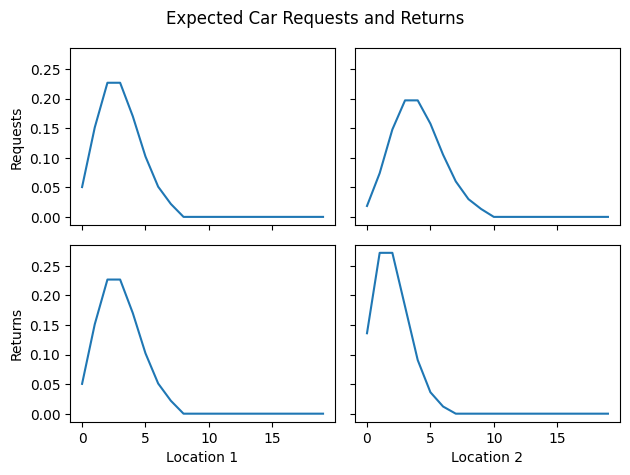

In [68]:
from itertools import count
from typing import Sequence
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson


class TruncatedPoisson:
    def __init__(
        self,
        mu: float,
        eps: float = 1e-2,
    ):
        self._mu = mu
        self._eps = eps
        self._lower = None
        self._upper = None
        self._pmf = []

        # underlying poisson
        rv = poisson(self._mu)

        for k in count(start=0):
            p = rv.pmf(k)
            if p > self._eps and self._lower is None:
                self._lower = k
                self._pmf.append(p)
            elif p < self._eps:
                break
            else:
                self._upper = k
                self._pmf.append(p)

        # normalize so that truncated PMF sums to 1
        self._pmf = np.array(self._pmf)
        self._pmf /= self._pmf.sum()

        self._k = np.arange(self._lower, self._upper + 1)

        print(
            f"TruncatedPoisson fitted: (mu={mu}, eps={eps}, lower={self._lower}, upper={self._upper})"
        )

    def k(self) -> Sequence[int]:
        return self._k

    def pmf(self, k: int) -> float:
        if k not in self._k:
            return 0
        return self._pmf[k]


requests_poisson = [TruncatedPoisson(mu=lam) for lam in config.requests_lambda]
returns_poisson = [TruncatedPoisson(mu=lam) for lam in config.returns_lambda]


def plot_poisson():
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

    ns = range(20)
    axs[0, 0].plot(ns, [requests_poisson[0].pmf(n) for n in ns])
    axs[0, 1].plot(ns, [requests_poisson[1].pmf(n) for n in ns])
    axs[1, 0].plot(ns, [returns_poisson[0].pmf(n) for n in ns])
    axs[1, 1].plot(ns, [returns_poisson[1].pmf(n) for n in ns])

    axs[1, 0].set_xlabel("Location 1")
    axs[1, 1].set_xlabel("Location 2")
    axs[0, 0].set_ylabel("Requests")
    axs[1, 0].set_ylabel("Returns")

    fig.suptitle("Expected Car Requests and Returns")

    plt.tight_layout()
    plt.show()


plot_poisson()

#### World Model

In [69]:
def states():
    for s1 in range(config.max_cars + 1):
        for s2 in range(config.max_cars + 1):
            yield s1, s2


def actions(s: tuple[int, int]):
    s1, s2 = s
    # cannot move more cars than:
    #  - max number of moves
    #  - cars available at source
    #  - spaces available at destination
    lower_bound = max(-config.max_moves, -s2, -(config.max_cars - s1))
    upper_bound = min(+config.max_moves, +s1, +(config.max_cars - s2))
    for a in range(lower_bound, upper_bound + 1):
        yield a


def rv_observations():
    for requests_1 in requests_poisson[0].k():
        for returns_1 in returns_poisson[0].k():
            for requests_2 in requests_poisson[1].k():
                for returns_2 in returns_poisson[1].k():
                    yield requests_1, returns_1, requests_2, returns_2


# cache for reward function r(s'|s,a)
R = np.zeros(
    (
        config.max_cars + 1,
        config.max_cars + 1,
        config.max_cars + 1,
        config.max_cars + 1,
        config.max_moves * 2 + 1,
    ),
    dtype=int,
)
# cache for transition function p(s'|s,a)
T = np.zeros(
    (
        config.max_cars + 1,
        config.max_cars + 1,
        config.max_cars + 1,
        config.max_cars + 1,
        config.max_moves * 2 + 1,
    ),
    dtype=float,
)

for s in states():
    s1, s2 = s
    for a in actions(s):
        for requests_1, returns_1, requests_2, returns_2 in rv_observations():
            fulfilled_1 = min(s1_next, requests_1)
            fulfilled_2 = min(s2_next, requests_2)

            # move cars
            s1_next = s1 - a
            s2_next = s2 + a

            # remove requested cars, add returned cars
            s1_next = min(s1_next - fulfilled_1 + returns_1, config.max_cars)
            s2_next = min(s2_next - fulfilled_2 + returns_2, config.max_cars)

            # keep track of probability of transition occuring:
            # - all random variables are independent of each other,
            #   so we compute their product
            joint_probability = (
                requests_poisson[0].pmf(requests_1)
                * returns_poisson[0].pmf(returns_1)
                * requests_poisson[1].pmf(requests_2)
                * returns_poisson[1].pmf(returns_2)
            )
            T[s1_next, s2_next, s1, s2, a] += joint_probability

            r = (
                config.move_reward * abs(a)
                + fulfilled_1 * config.rent_reward
                + fulfilled_2 * config.rent_reward
            )
            R[s1_next, s2_next, s1, s2, a] += r

nonzero = T > 0
R[nonzero] = R[nonzero] / T[nonzero]

#### Policy Iteration

105572.82504339237


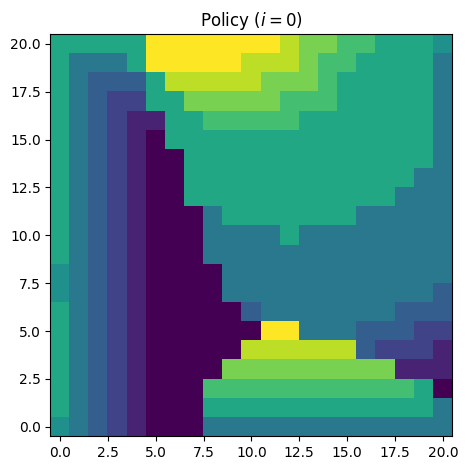

14472.134377554525


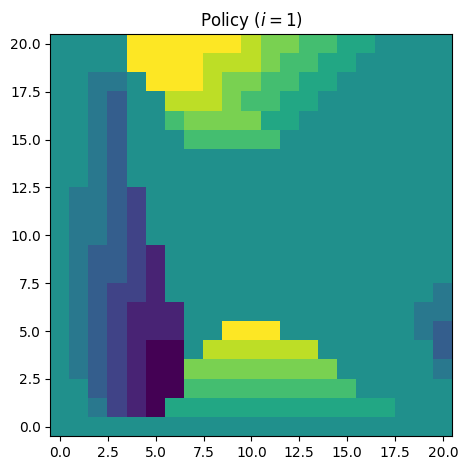

3941.763827037066


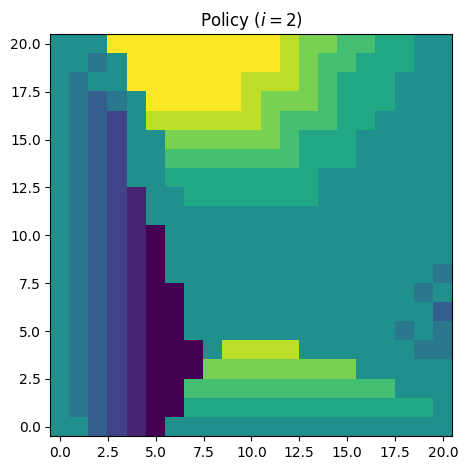

791.675688832067


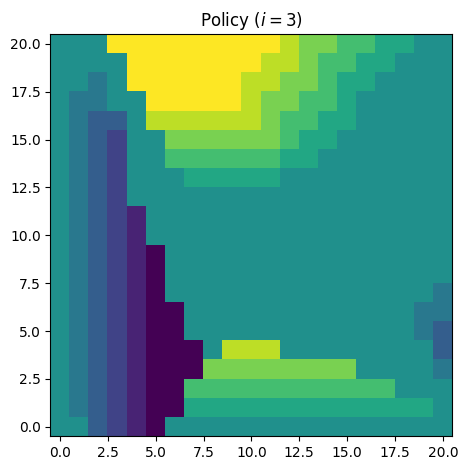

128.35034749936312


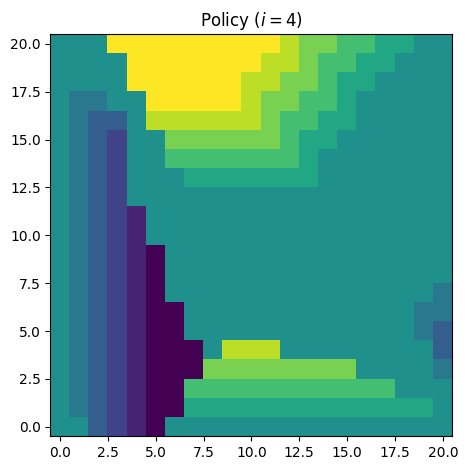

15.972619209904224


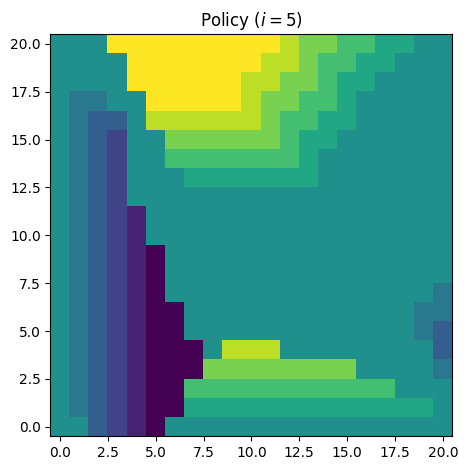

In [71]:
from typing import Optional


V = np.zeros((config.max_cars + 1, config.max_cars + 1), dtype=float)
pi = np.zeros((config.max_cars + 1, config.max_cars + 1), dtype=int)


def expected_return(s: tuple[int, int], a: int) -> float:
    return np.sum(T[:, :, *s, a] * (R[:, :, *s, a] + config.gamma * V))


def evaluation(max_iter: int = 10, theta: float = 0.1):
    for _ in range(max_iter):
        delta = 0
        for s in states():
            v = V[s]
            V[s] = expected_return(s, pi[s])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    print(delta)


def improvement():
    policy_stable = True
    for s in states():
        old_a = pi[s]
        best_a, best_v = pi[s], V[s]
        for a in actions(s):
            if a == old_a:
                continue
            v = expected_return(s, a)
            if v > best_v:
                best_a, best_v = a, v
        pi[s] = best_a
        if pi[s] != old_a:
            policy_stable = False
    return policy_stable


def policy_iteration(max_iter: int = 10):
    for i in range(max_iter):
        evaluation()

        policy_stable = improvement()
        plot_pi(i)

        if policy_stable:
            return


def plot_pi(i: Optional[int] = None):
    fig, ax = plt.subplots()
    ax.imshow(pi, cmap="viridis")
    ax.invert_yaxis()
    ax.set_title(f"Policy ($i={i}$)" if i is not None else "Policy")
    plt.tight_layout()
    plt.show()


def plot_V(i: Optional[int] = None):
    fig, ax = plt.subplots()
    ax.imshow(pi, cmap="viridis")
    ax.invert_yaxis()
    ax.set_title(f"V ($i={i}$)" if i is not None else "V")
    plt.tight_layout()
    plt.show()


policy_iteration()

In [ ]:
plot_V()